# TODO

# Load data

In [1]:
import torch
import pandas as pd

from iterativennsimple.Sequential2D import Sequential2D, Identity
from iterativennsimple.Sequential1D import Sequential1D

from iterativennsimple.SparseLinear import SparseLinear

from iterativennsimple.utils.plot_2D_start_end import plot_2D_start_end

In [2]:
# Neil, this code is a little unstable, mainly because of the way I'm doing the intialization of the weights.   
# I put this here just for pedagogical purposes.  Be sure to remove for real runs!
torch.manual_seed(0)
#torch.use_deterministic_algorithms(True)


In [3]:
# Turn a pandas dataframe into a pytorch tensor
def df_to_tensor(df):
    return torch.tensor(df.values, dtype=torch.float32)

In [4]:
#name = 'regression_line'
#name = 'pca_line'
#name = 'circle'
#name = 'regression_circle'
#one_hot_y = False

name = 'MNIST'
one_hot_y = True

# Read the start data
z_start = pd.read_parquet(f'../data/processed/{name}_start.parquet')
# Read the target data
z_target = pd.read_parquet(f'../data/processed/{name}_target.parquet')

## Data preprocessing

In [5]:
z_start_tensor = df_to_tensor(z_start)
z_target_tensor = df_to_tensor(z_target)

# Only use the given number of sample
max_num_samples = 500
num_samples = min(max_num_samples, z_start_tensor.shape[0])
z_start_tensor = z_start_tensor[:num_samples]
z_target_tensor = z_target_tensor[:num_samples]

We have two views of the data, and here is where we reconcile them.   The dynamical systems view is to have vector $z_0$ (called "z_start_tensor" in the code) and $z_1$ (called "z_target_tensor" in the code) that are the initial and final states of the system.  We want to construct a function $f$ (or more precisely choose a set of parameters $\theta$ that selects $f$ from some family of functions) such that $\|f(z_0) - z_1\|$ is small.  The machine learning view is to have a set of inputs $x$ (which is a subset of "z_start_tensor") and a set of outputs $y$ (which is a subset of "z_target_tensor") and to construct a function $g$ (or more precisely choose a set of parameters $\phi$ that selects $g$ from some family of functions) such that $\|g(x) - y\|$ is small.   

**The idea is to have $x$ and $y$ be subsets of $z_0$ and $z_1$ respectively!**   But how to do that!?

Let's begin by writing 

$$
z_i=
\begin{bmatrix}
x_i \\
y_i \\
\end{bmatrix}
$$

and **we assume that $x_0=x_1$**.  This may seem odd at first glance, but is actually quite natural.  For example, in our MNIST example the starting image in $x_0$ and the target image in $x_1$ are the same.  It is merely the classification in $y_0$ and $y_1$ that are different.  I.e., $y_0$ contains some noisy classification or uniform prior of $x_0$ and $y_1$ contains the correct classification of $x_0$.  In the case of the MNIST data, we have $x_0=x_1$ and $y_0\neq y_1$.

So, in slighltly more detail we choose $z_0$ and $z_1$ so that

$$
z_0=
\begin{bmatrix}
x_0 \\
y_0 \\
\end{bmatrix}
$$

and

$$
z_1=
\begin{bmatrix}
x_0 \\
y_1 \\
\end{bmatrix}
$$

In [6]:
# compute a mask for the data where every entry in each column is the same
# this is used to remove columns that are constant
mask = (z_start_tensor == z_target_tensor).all(axis=0)
mask.shape
x_mask = mask
y_mask = ~mask

# print out the shape of the masks
print(x_mask.shape, y_mask.shape)

# print out number of true entries in each mask
print(x_mask.sum(), y_mask.sum())


torch.Size([785]) torch.Size([785])
tensor(784) tensor(1)


# MLP model

Now we start using Sequential2D to build our model.  This requires a little massaging of the data.  In particlar, remember that we now have an iterative map of the form

$$
\begin{bmatrix}
I   & 0   & 0   & 0 \\
f_1 & 0   & 0   & 0 \\
0   & f_2 & 0   & 0 \\
0   & 0   & f_3 & 0 \\
\end{bmatrix}
$$

and a state vector that combines $x$, $y$, and *the hidden layers* in the following way.

$$
\begin{bmatrix}
I   & 0   & 0   & 0 \\
f_1 & 0   & 0   & 0 \\
0   & f_2 & 0   & 0 \\
0   & 0   & f_3 & 0 \\
\end{bmatrix}
\circ
\begin{bmatrix}
x_0 \\
h_1 \\
h_2 \\
y_0 \\
\end{bmatrix}
$$

I am feeling a little silly today, so let's do the rest using Achilles and the Hare from Godel, Escher, Bach.

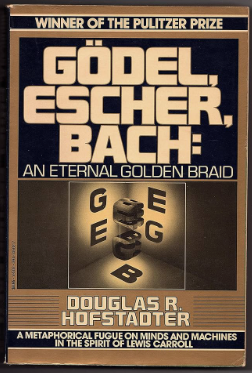

Achilles:  But... didn't you just say that an normal ML algorithm link and MLP ignores $y_0$?  Look, doesn't $y_0$ appear right up there?  

Hare: Well, look at what happens after the first iteration.

$$
\begin{bmatrix}
I   & 0   & 0   & 0 \\
f_1 & 0   & 0   & 0 \\
0   & f_2 & 0   & 0 \\
0   & 0   & f_3 & 0 \\
\end{bmatrix}
\circ
\begin{bmatrix}
x_0 \\
h_1 \\
h_2 \\
y_0 \\
\end{bmatrix}
=
\begin{bmatrix}
x_0 \\
f_1(x_0) \\
f_2(h_1) \\
f_3(h_2) \\
\end{bmatrix}
$$

which **does not** contain $y_0$!  The MLP is cunningly designed to ignore the initial guess contained in $y_0$ :-)

Achilles:  But... but... but...  what about the hidden layers $h_1$ and $h_2$?  Don't you need to choose them carefully since they are the input to the next layer\iteration?  I remember reading that MLPs don't care about random initializations of the hidden layers since they will be overwritten by the training process!?

Hare: Yes, but...  look at what happens after the second iteration.

$$
\begin{bmatrix}
I   & 0   & 0   & 0 \\
f_1 & 0   & 0   & 0 \\
0   & f_2 & 0   & 0 \\
0   & 0   & f_3 & 0 \\
\end{bmatrix}
\circ
\begin{bmatrix}
I   & 0   & 0   & 0 \\
f_1 & 0   & 0   & 0 \\
0   & f_2 & 0   & 0 \\
0   & 0   & f_3 & 0 \\
\end{bmatrix}
\circ
\begin{bmatrix}
x_0 \\
h_1 \\
h_2 \\
y_0 \\
\end{bmatrix}
=
\begin{bmatrix}
x_0 \\
f_1(x_0) \\
f_2(f_1(x_0)) \\
f_3(f_2(h_1)) \\
\end{bmatrix}
$$


Hare: And one more iteration gives

$$
\begin{bmatrix}
I   & 0   & 0   & 0 \\
f_1 & 0   & 0   & 0 \\
0   & f_2 & 0   & 0 \\
0   & 0   & f_3 & 0 \\
\end{bmatrix}
\circ
\begin{bmatrix}
I   & 0   & 0   & 0 \\
f_1 & 0   & 0   & 0 \\
0   & f_2 & 0   & 0 \\
0   & 0   & f_3 & 0 \\
\end{bmatrix}
\circ
\begin{bmatrix}
I   & 0   & 0   & 0 \\
f_1 & 0   & 0   & 0 \\
0   & f_2 & 0   & 0 \\
0   & 0   & f_3 & 0 \\
\end{bmatrix}
\circ
\begin{bmatrix}
x_0 \\
h_1 \\
h_2 \\
y_0 \\
\end{bmatrix}
=
\begin{bmatrix}
x_0 \\
f_1(x_0) \\
f_2(f_1(x_0)) \\
f_3(f_2(f_1(x_0))) \\
\end{bmatrix}
$$

Two neat things have happened. First notice that the hidden layers $h_1$ and $h_2$ have been overwritten by the training process, so their initiationlization is irrelevant.  Second, we have the last entry has the form $f_3(f_2(f_1(x_0)))$ which is exactly the form of the answer that the MLP would have given!

Hare:  So, the MLP is a cunningly designed iterative map that ignores the initial guess $y_0$ and the hidden layers $h_1$ and $h_2$ and gives the same answer as the iterative map that we are trying to learn!  

In [7]:
input_size = int(x_mask.sum())
h1_size = 20
h2_size = 20
output_size = int(y_mask.sum())

x_idx = torch.arange(0, input_size)
h_idx = torch.arange(input_size, input_size+h1_size+h2_size)
y_idx = torch.arange(input_size+h1_size+h2_size, input_size+h1_size+h2_size+output_size)

total_size = input_size + h1_size + h2_size + output_size

iterations = 3
sparsity = 'R=0.4'

I = Identity(in_features=input_size, out_features=input_size)

l1 = SparseLinear.from_singleBlock(col_size=input_size, row_size=h1_size,  
                                   block_type=sparsity, initialization_type='G=0.0,0.001', 
                                   optimized_implementation=True)
f1 = Sequential1D(l1, 
                  torch.nn.ReLU(), 
                  in_features=input_size, out_features=h1_size)


l2 = SparseLinear.from_singleBlock(col_size=h1_size, row_size=h2_size,  
                                   block_type=sparsity, initialization_type='G=0.0,0.001', 
                                   optimized_implementation=True)
f2 = Sequential1D(l2, 
                  torch.nn.ReLU(), 
                  in_features=h1_size,    out_features=h2_size)

f3 = SparseLinear.from_singleBlock(col_size=h2_size, row_size=output_size,  
                                   block_type=sparsity, initialization_type='G=0.0,0.001', 
                                   optimized_implementation=True)

in_features_list  = [input_size, h1_size, h2_size, output_size]
out_features_list = [input_size, h1_size, h2_size, output_size]
blocks = [[I,    None, None, None],
          [f1,   None, None, None],
          [None, f2,   None, None],
          [None, None, f3,   None]]

def transpose_blocks(blocks):
    return [[blocks[j][i] for j in range(len(blocks))] for i in range(len(blocks[0]))]

map = Sequential2D(
    in_features_list=in_features_list,
    out_features_list=out_features_list,
    blocks=transpose_blocks(blocks)
)   

/home/rcpaffenroth/projects/iterativennsimple/.venv/lib/python3.10/site-packages/iterativennsimple/SparseLinear.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.sparse_trainable_values = torch.nn.parameter.Parameter(torch.tensor(sparse_trainable.values(), **factory_kwargs),


In [8]:
zh_start_tensor = torch.cat((z_start_tensor[:, x_mask],
                             torch.zeros(z_start_tensor.shape[0], len(h_idx)), 
                             z_start_tensor[:, y_mask]), dim=1)
zh_target_tensor = torch.cat((z_target_tensor[:, x_mask], 
                             torch.zeros(z_target_tensor.shape[0], len(h_idx)), 
                             z_target_tensor[:, y_mask]), dim=1)

In [9]:
# a dataloader which returns a batch of start and target data
class Data(torch.utils.data.Dataset):
    def __init__(self, z_start, z_target):
        self.z_start = z_start
        self.z_target = z_target
    def __len__(self):
        return len(self.z_start)
    def __getitem__(self, idx):
        return self.z_start[idx], self.z_target[idx]
    
train_data = Data(zh_start_tensor, zh_target_tensor)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True)

In [10]:
# Define the loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(map.parameters(), lr=0.001)

In [11]:
max_epochs = 100
# Train the model
for epoch in range(max_epochs):
    for batch_idx, (start, target) in enumerate(train_loader):
        optimizer.zero_grad()

        mapped = start

        loss = 0.0
        for i in range(iterations):
            mapped = map(mapped)

        loss = criterion(mapped[:, y_idx], target[:, y_idx])
        loss.backward()

        optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Batch {batch_idx}, Loss {loss.item()}')

Epoch 0, Batch 4, Loss 15.79990005493164


Epoch 10, Batch 4, Loss 7.968173027038574
Epoch 20, Batch 4, Loss 8.686362266540527
Epoch 30, Batch 4, Loss 8.103934288024902
Epoch 40, Batch 4, Loss 7.142888069152832
Epoch 50, Batch 4, Loss 10.121956825256348
Epoch 60, Batch 4, Loss 9.089917182922363
Epoch 70, Batch 4, Loss 8.78259563446045
Epoch 80, Batch 4, Loss 8.47742748260498
Epoch 90, Batch 4, Loss 7.190887928009033
